<a href="https://colab.research.google.com/github/juyeeeeon/pytorch_newbie/blob/main/6_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6.1> 합성곱 연산과 풀링 연산**

# **6.1.1) 이미지 데이터**

# **6.1.2) MLP와 이미지 처리**

# **6.1.3) 합성곱 연산과 풀링 연산**

필터(filter), 커널(kernel)

-합성곱 연산

보폭(stride), 패딩(padding)

nn.Conv2d

torch.nn.functional.conv2d

-풀링 연산

최댓값 풀링(max pooling), 평균값 풀링(average pooling)

풀링은 커널의 크기와 보폭을 같게 함으로써 이동하는 커너링 같은 부분을 중복 계산하지 않게 한다.(non-overlapping pooling)

즉, 영역별 대푯값을 하나씩 뽑아내는 연산이며 주로 컨볼루션 층 다음에 배치한다.

nn.AvgPool2d

torch.nn.functional.avg_pool2d

nn.MaxPool2d

torch.nn.functional.max_pool2d



# **6.2> AlexNet**

In [19]:
#라이브러리 불러오기

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [20]:
#CIFAR10 데이터 세트 불러오기

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False) 

Files already downloaded and verified
Files already downloaded and verified


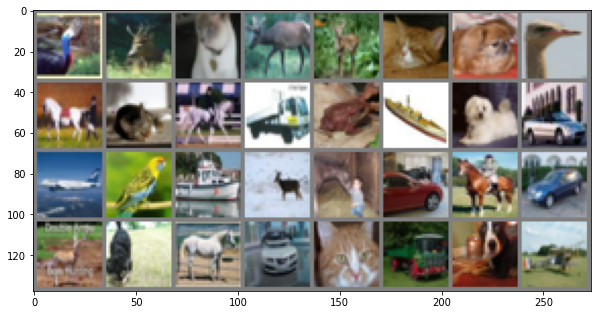

torch.Size([32, 3, 32, 32])


In [21]:
#배치 및 이미지 크기 확인인

def imshow(img):
  img = .5*img + .5
  plt.figure(figsize=(10, 100))
  plt.imshow(img.permute(1,2,0).numpy())
  plt.show()

images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.size())

In [22]:
#GPU 연산 체크하기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [23]:
#AlexNet 구축하기
# Conv→ReLU→MaxPool→ Conv→ReLU→MaxPool→Conv→ReLU→ Conv→ReLU→Conv→ReLU→MaxPool→FC1→ReLU→FC2→ReLU→FC3

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 1), nn.ReLU(),
                        nn.MaxPool2d(2, 2)        
                        )
        
        self.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256*3*3, 1024), nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1024, 512), nn.ReLU(),
                        nn.Linear(512, 10)
                        )    
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)    
        return x


In [24]:
print(alexnet)
PATH = './models/cifar_alexnet.pth' # 모델 저장 경로 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Lin

In [25]:
#손실함수 및 최적화 방법 정의하기

criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device) # 모델 선언
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [26]:
#AlexNet 모델 학습하기

loss_ = []
n = len(trainloader)
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = alexnet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_.append(running_loss / n)
  print('[%d] loss : %.3f' % (epoch+1, running_loss/len(trainloader)))

[1] loss : 1.590
[2] loss : 1.187
[3] loss : 0.995
[4] loss : 0.871
[5] loss : 0.780
[6] loss : 0.710
[7] loss : 0.661
[8] loss : 0.609
[9] loss : 0.564
[10] loss : 0.536
[11] loss : 0.508
[12] loss : 0.476
[13] loss : 0.458
[14] loss : 0.448
[15] loss : 0.421
[16] loss : 0.402
[17] loss : 0.388
[18] loss : 0.374
[19] loss : 0.356
[20] loss : 0.344
[21] loss : 0.335
[22] loss : 0.327
[23] loss : 0.315
[24] loss : 0.301
[25] loss : 0.300
[26] loss : 0.283
[27] loss : 0.273
[28] loss : 0.265
[29] loss : 0.267
[30] loss : 0.262
[31] loss : 0.271
[32] loss : 0.243
[33] loss : 0.242
[34] loss : 0.248
[35] loss : 0.230
[36] loss : 0.248
[37] loss : 0.236
[38] loss : 0.226
[39] loss : 0.225
[40] loss : 0.233
[41] loss : 0.233
[42] loss : 0.220
[43] loss : 0.215
[44] loss : 0.211
[45] loss : 0.239
[46] loss : 0.234
[47] loss : 0.239
[48] loss : 0.268
[49] loss : 0.205
[50] loss : 0.232


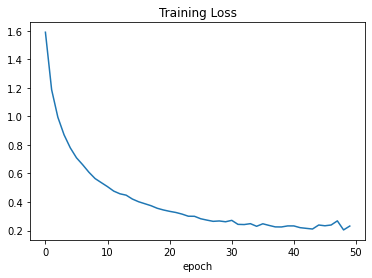

In [27]:
#학습 손실 함수 그래프 그리기

plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [28]:
#파이토치 모델 저장 및 불러오기

PATH = './models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

In [31]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다. 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

alexnet = AlexNet().to(device) # 모델 선언
alexnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

In [32]:
#평가하기

correct=0
total=0

with torch.no_grad():
  alexnet.eval()
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = alexnet(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test accuracy: %.2f %%' % (100*correct / total))

Test accuracy: 77.19 %


# **6.3> ResNet**